# Predicting E-Commerce Product Recommendations from Reviews 

__Main Objective:__ Leverage the review text attributes and build deep learning models to predict the recommendation (classification)

# Load up basic dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load and View the Dataset

The data is available at https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews.

In [3]:
df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Basic Data Processing

- Merge all review text attributes (title, text description) into one attribute
- Subset out columns of interest

In [4]:
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df.head()

,Review,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws I had such high hopes ...,0
3,"My favorite buy! I love, love, love this jumps...",1
4,Flattering shirt This shirt is very flattering...,1


## Remove all records with no review text

### Remove records with no reviews

In [5]:
df['Review'].replace('', np.nan, inplace=True)
df.dropna(subset=['Review'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22642 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       22642 non-null  object
 1   Recommended  22642 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.7+ KB


## View product recommendations by yes or no

In [6]:
df['Recommended'].value_counts()

1    18541
0     4101
Name: Recommended, dtype: int64

# Build train and test datasets

### Prepare train-test split with ``Recommended`` column as the target variable.

In [7]:
from sklearn.model_selection import train_test_split
X = df.drop(['Recommended'],axis=1)
y = df['Recommended']	
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape

((18113, 1), (4529, 1))

In [8]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({1: 14810, 0: 3303}), Counter({1: 3731, 0: 798}))

In [9]:
X_train.head(3)

,Review
21506,Not for the petite I love the design and color...
18545,I love the color and style of this dress. and ...
13333,"Beautiful, substantial jacket I pair this jack..."


In [10]:
y_train[:3]

21506    1
18545    0
13333    1
Name: Recommended, dtype: int64

# Text Pre-processing and Wrangling

In [11]:
import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs


In [12]:
X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

100%|██████████| 4529/4529 [00:00<00:00, 9700.01it/s]


# Train Classfier with CNN + FastText Embeddings & Evaluate Performance on Test Data

Build a classifier using FastText Embeddings

In [13]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_train['Clean Review'])
t.word_index['<PAD>'] = 0

In [14]:
# to check: get mapping for the word with maximum and minimum index and also the index for 
# <UNK>
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('toms', 12835) ('<PAD>', 0) 1


In [15]:
train_sequences = t.texts_to_sequences(X_train['Clean Review'])
test_sequences = t.texts_to_sequences(X_test['Clean Review'])

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=12836
Number of Documents=18113


(0.0, 150.0)

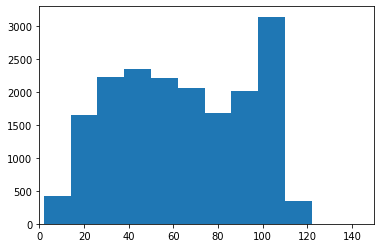

In [16]:
plt.hist([len(doc.split()) for doc in X_train['Clean Review']], bins=10);
plt.xlim([0, 150])

In [17]:
MAX_SEQUENCE_LENGTH = 130

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((18113, 130), (4529, 130))

In [18]:
#build embedding matrix
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [19]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2022-08-21 23:54:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.3’

wiki-news-300d-1M.v 100%[===================>] 650.22M  25.0MB/s    in 27s     

2022-08-21 23:55:12 (23.7 MB/s) - ‘wiki-news-300d-1M.vec.zip.3’ saved [681808098/681808098]



In [20]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [21]:
#generate pre-trained embedding matrix
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):  
    """
    Utility function to load the pre-trained embeddings
    """  
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [22]:
# get FastText embeddings based on our word to index mapping dictionary
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(12836, 300)

In [23]:
# create the model
model = tf.keras.models.Sequential()

# the weights of the embedding layer are FastText weights
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 300)          3850800   
                                                                 
 conv1d (Conv1D)             (None, 130, 256)          307456    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 64)            3

In [24]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
142/142 [==============================] - 9s 19ms/step - loss: 0.3348 - accuracy: 0.8553 - val_loss: 0.2037 - val_accuracy: 0.9148
Epoch 2/100
142/142 [==============================] - 2s 17ms/step - loss: 0.1791 - accuracy: 0.9252 - val_loss: 0.1868 - val_accuracy: 0.9234
Epoch 3/100
142/142 [==============================] - 2s 17ms/step - loss: 0.1358 - accuracy: 0.9483 - val_loss: 0.2150 - val_accuracy: 0.9203
Epoch 4/100
142/142 [==============================] - 2s 16ms/step - loss: 0.0880 - accuracy: 0.9671 - val_loss: 0.2486 - val_accuracy: 0.9176
Epoch 4: early stopping


In [25]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

predict_probas = model.predict(X_test)
predict_probas = predict_probas.ravel()

predictions = [1 if proba >0.5 else 0 for proba in predict_probas]

# print classification report
print(classification_report(y_test, predictions))
# display confusion matrix
pd.DataFrame(confusion_matrix(y_test, predictions))

142/142 [==============================] - 1s 3ms/step - loss: 0.1868 - accuracy: 0.9234
Accuracy: 92.34%
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       798
           1       0.96      0.95      0.95      3731

    accuracy                           0.92      4529
   macro avg       0.87      0.87      0.87      4529
weighted avg       0.92      0.92      0.92      4529



,0,1
0,638,160
1,187,3544


# Train Classfier with LSTM + FastText Embeddings & Evaluate Performance on Test Data

### Build a classifier using FastText Embeddings and LSTMs

In [26]:
#Build the LSTM model
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # LSTM hidden state dimensionality 

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=EMBEDDING_DIM, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.SpatialDropout1D(0.1))

model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 300)          3850800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,103,729
Trainable params: 4,103,729
Non-trainable params: 0
____________________________________________

In [27]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
128/128 [==============================] - 5s 21ms/step - loss: 0.3336 - accuracy: 0.8621 - val_loss: 0.2372 - val_accuracy: 0.8990
Epoch 2/10
128/128 [==============================] - 2s 17ms/step - loss: 0.1924 - accuracy: 0.9210 - val_loss: 0.2298 - val_accuracy: 0.9034
Epoch 3/10
128/128 [==============================] - 2s 17ms/step - loss: 0.1497 - accuracy: 0.9413 - val_loss: 0.2883 - val_accuracy: 0.8797
Epoch 4/10
128/128 [==============================] - 2s 17ms/step - loss: 0.1115 - accuracy: 0.9581 - val_loss: 0.3393 - val_accuracy: 0.8902
Epoch 4: early stopping


In [28]:
# Final evaluation of the LSTM model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

predict_probas = model.predict(X_test)
predict_probas = predict_probas.ravel()

predictions = [1 if proba >0.5 else 0 for proba in predict_probas]

# print classification report
print(classification_report(y_test, predictions))
# display confusion matrix
pd.DataFrame(confusion_matrix(y_test, predictions))

142/142 [==============================] - 1s 5ms/step - loss: 0.2148 - accuracy: 0.9117
Accuracy: 91.17%
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       798
           1       0.95      0.94      0.95      3731

    accuracy                           0.91      4529
   macro avg       0.84      0.86      0.85      4529
weighted avg       0.91      0.91      0.91      4529



,0,1
0,628,170
1,230,3501


# Train Classfier with NNLM Universal Embedding Model

### Build a classifier using NNLM Universal Embeddings

In [29]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)

In [30]:
model = tf.keras.models.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,675,841
Trainable params: 124,675,84

In [31]:
#train and validate model
EPOCHS=100
BATCH_SIZE=128

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape

norm_train_texts = normalize_corpus(list(X_train['Review'].values))
norm_test_texts = normalize_corpus(list(X_test['Review'].values))

# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
    
model.fit(np.array(norm_train_texts), y_train, 
          validation_data=(np.array(norm_test_texts), y_test),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

100%|██████████| 4529/4529 [00:00<00:00, 17090.67it/s]


Epoch 1/100
142/142 [==============================] - 7s 42ms/step - loss: 0.3180 - accuracy: 0.8599 - val_loss: 0.2080 - val_accuracy: 0.9130
Epoch 2/100
142/142 [==============================] - 6s 39ms/step - loss: 0.1869 - accuracy: 0.9217 - val_loss: 0.1995 - val_accuracy: 0.9190
Epoch 3/100
142/142 [==============================] - 6s 39ms/step - loss: 0.1512 - accuracy: 0.9399 - val_loss: 0.2143 - val_accuracy: 0.9196
Epoch 4/100
142/142 [==============================] - 5s 39ms/step - loss: 0.1223 - accuracy: 0.9518 - val_loss: 0.2343 - val_accuracy: 0.9123
Epoch 5/100
142/142 [==============================] - 5s 38ms/step - loss: 0.0961 - accuracy: 0.9635 - val_loss: 0.2511 - val_accuracy: 0.9073
Epoch 5: early stopping


In [32]:
# Final evaluation of the model
scores = model.evaluate(np.array(norm_test_texts), y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

predict_probas = model.predict(np.array(norm_test_texts))
predict_probas = predict_probas.ravel()

predictions = [1 if proba >0.5 else 0 for proba in predict_probas]

# print classification report
print(classification_report(y_test, predictions))
# display confusion matrix
pd.DataFrame(confusion_matrix(y_test, predictions))

142/142 [==============================] - 1s 5ms/step - loss: 0.1995 - accuracy: 0.9190
Accuracy: 91.90%
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       798
           1       0.94      0.96      0.95      3731

    accuracy                           0.92      4529
   macro avg       0.87      0.85      0.86      4529
weighted avg       0.92      0.92      0.92      4529



,0,1
0,585,213
1,154,3577


# Train Classfier with BERT

### Build a classifier using BERT Embeddings

In [33]:
!pip install transformers --ignore-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.21.1-py3-none-any.whl (4.7 MB)
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Using cached regex-2022.8.17-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (752 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached importlib_metadata-4.12.0-py3-none-any.whl (21 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached huggingface_hub-0.8.1-py3-none-any.whl (101 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached typing_extensions-4.3.0-py3-none-any.whl (25 kB)

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df = df[df['Review'] != '']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)

import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']


100%|██████████| 6793/6793 [00:00<00:00, 17749.24it/s]


#### Train and Evaluate the BERT model using `transformers`

In [35]:
import transformers

In [36]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

#load BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [37]:
#function to tokenize and encode text into BERT token IDs
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # ones for all tokens
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [38]:
#BERT model architecture
MAX_SEQ_LENGTH = 130

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 130)]        0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 130)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]',   

In [39]:
#Feature ID, masks and segments for train and test sets
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_clean_text, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_clean_text, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)

print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 6793/6793 [00:09<00:00, 680.30it/s]

Train Features: (15849, 130) (15849, 130) (15849, 130)
Test Features: (6793, 130) (6793, 130) (6793, 130)


In [40]:
#train the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], y_train, 
          validation_data=([test_features_ids, 
                            test_features_masks, 
                            test_features_segments], y_test),
          epochs=3, 
          batch_size=8, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/3
1982/1982 [==============================] - 401s 195ms/step - loss: 0.2262 - accuracy: 0.9025 - val_loss: 0.1802 - val_accuracy: 0.9270
Epoch 2/3
1982/1982 [==============================] - 380s 192ms/step - loss: 0.1377 - accuracy: 0.9446 - val_loss: 0.2346 - val_accuracy: 0.9232
Epoch 2: early stopping


In [42]:
#evaluate BERT model
from sklearn.metrics import accuracy_score
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 92.70%
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      1218
           1       0.94      0.97      0.96      5575

    accuracy                           0.93      6793
   macro avg       0.90      0.84      0.87      6793
weighted avg       0.92      0.93      0.92      6793



,0,1
0,862,356
1,140,5435


# Train Classfier with DistilBERT


### Build a classifier using DistilBERT Embeddings

In [43]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [44]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        all_ids.append(ids)
        all_masks.append(masks)
        
    encoded = np.array([all_ids, all_masks])
    
    return encoded

In [45]:
MAX_SEQ_LENGTH = 150

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 150)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['bert_input_ids[0][0]',         
 BertModel)                     ast_hidden_state=(N               'bert_input_masks[0][0]']       
                                one, 150, 768),                                                   
                                 hidden_states=None                                         

In [47]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_clean_text, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_clean_text, 
                                                                    max_seq_length=MAX_SEQ_LENGTH)

print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 6793/6793 [00:09<00:00, 701.09it/s]


Train Features: (15849, 150) (15849, 150)
Val Features: (6793, 150) (6793, 150)


In [48]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks], y_train, 
          validation_data=([test_features_ids, 
                            test_features_masks], y_test),
          epochs=3, 
          batch_size=20, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/3
793/793 [==============================] - 195s 234ms/step - loss: 0.2307 - accuracy: 0.9027 - val_loss: 0.1707 - val_accuracy: 0.9292
Epoch 2/3
793/793 [==============================] - 184s 232ms/step - loss: 0.1485 - accuracy: 0.9409 - val_loss: 0.1947 - val_accuracy: 0.9295
Epoch 2: early stopping


In [49]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 92.92%
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1218
           1       0.96      0.95      0.96      5575

    accuracy                           0.93      6793
   macro avg       0.88      0.89      0.88      6793
weighted avg       0.93      0.93      0.93      6793



,0,1
0,1004,214
1,267,5308
